Reference:
1. [Lin, Y.-X., McCrae, M., and Gulati, C., 2006. **Loss protection in pairs trading through minimum profit bounds: a cointegration approach**](http://downloads.hindawi.com/archive/2006/073803.pdf)

2. [Puspaningrum, H., Lin, Y.-X., and Gulati, C. M. 2010. **Finding the optimal pre-set boundaries for pairs trading strategy based on cointegration technique**](https://ro.uow.edu.au/cgi/viewcontent.cgi?article=1040&context=cssmwp)


# Minimum Profit Optimization

## Introduction

A common pairs trading strategy is to "fade the spread", i.e. to open a trade when the spread is sufficiently far away
from its equilibrium in anticipation of the spread reverting to the mean. Within the context of cointegration, the
spread refers to cointegration error, and in the remainder of this documentation "spread" and "cointegration error" will
be used interchangeably.

In order to define a strategy, we need to quantify the concept of "sufficiently far away from the equilibrium of the
spread", i.e. a pre-set boundary chosen to open a trade, for this boundary can affect the minimum total profit (MTP)
over a specific trading horizon. The higher the pre-set boundary for opening trades, the higher the profit per trade
but the lower the trade numbers. The opposite applies for lowering the boundary values. The number of trades over a
specified trading horizon is determined jointly by the average trade duration and the average inter-trade interval.

In this notebook, we will demonstrate how to optimize the pre-set boundary that would maximize the MTP for cointegration error
following an AR(1) process by numerically estimating the average trade duration, average inter-trade interval, and the
average number of trades based on the mean first-passage time.

## Model Assumptions

Before getting into the nuts and bolts of the optimization process, we need to articulate the assumptions of the cointegration pairs trading strategy.

- The price of two assets ($S_1$ and $S_2$) are cointegrated over the relevant time period, which includes both in-sample and out-of-sample (trading) period.
- The cointegration error follows a stationary AR(1) process.
- The cointegration error is symmetrically distributed so that we can apply the optimal boundary on both sides of the mean.
- Short sales are permitted or possible through a broker and there is no interest charged for the short sales and no cost for trading.
- The cointegration coefficient $\beta > 0$, where a cointegration relationship is defined as:

\begin{equation}
    P_{S_1,t} - \beta P_{S_2,t} = \varepsilon_t
\end{equation}

## Minimum Profit per Trade

Denote a trade opened when the cointegration error $\varepsilon_t$ overshoots the pre-set upper boundary $U$
as a **U-trade**, and similarly a trade opened when $\varepsilon_t$ falls through the pre-set lower
boundary $L$ as an **L-trade**. Without loss of generality, we assume the mean of $\varepsilon_t$ is 0. 

### Minimum Profit per U-trade

The setup of a U-trade is as follows:

- When $\varepsilon_t \geq U$ at $t_o$, we open a trade by selling $N$ of asset $S_1$ and buying $\beta N$ of asset $S_2$.
- When $\varepsilon_t \leq 0$ at $t_c$, we square the trade.

The profit per trade would thus be:

\begin{equation}
    P = N (P_{S_1, t_o} - P_{S_1, t_c}) + \beta N (P_{S_2, t_c} - P_{S_2, t_o})
\end{equation}

Since the two assets are cointegrated during the trade period, we can substitute the cointegration relationship into
the above equation and derive the following:

\begin{align*}
    P & =  N (P_{S_1, t_o} - P_{S_1, t_c}) + \beta N (P_{S_2, t_c} - P_{S_2, t_o}) \\
      & =  N (P_{S_1, t_o} - \beta P_{S_2, t_o}) - N (P_{S_1, t_c} - \beta P_{S_2, t_c}) \\
      & =  N \varepsilon_{t_o} - N \varepsilon_{t_c} \\
      & \geq N U
\end{align*}

### Minimum Profit per L-trade

The setup of a L-trade is as follows:

- When $\varepsilon_t \leq -U$ at $t_o$, we open a trade by buying $N$ of asset $S_1$ and selling $\beta N$ of asset $S_2$.
- When $\varepsilon_t \geq 0$ at $t_c$, we square the trade.

The profit per trade would thus be:

\begin{equation}
    P = N (P_{S_1, t_c} - P_{S_1, t_o}) + \beta N (P_{S_2, t_o} - P_{S_2, t_c})
\end{equation}

Since the two assets are cointegrated during the trade period, we can substitute the cointegration relationship into
the above equation and derive the following:

\begin{align*}
    P & =  N (P_{S_1, t_c} - P_{S_1, t_o}) + \beta N (P_{S_2, t_o} - P_{S_2, t_c}) \\
      & =  N (P_{S_1, t_c} - \beta P_{S_2, t_c}) - N (P_{S_1, t_o} - \beta P_{S_2, t_o}) \\
      & =  N \varepsilon_{t_c} - N \varepsilon_{t_o} \\
      & \geq N U
\end{align*}

**Both U-trades and L-trades would make a minimum profit per trade of $U$ if one unit of the cointegrated pair ($N=1$) were traded.**

## Minimum Total Profit (MTP)

Based on the assumption that the boundary to open trades would be symmetrically applied on both sides of the spread mean, we will focus only on U-trade in this section. We can simply double the results to take L-trades into account.

We have derived the minimum profit per U-trade, and the next question of interest is the MTP over a trading horizon $[0,T]$. We would like to find the optimal boundary $U$ that can allow enough trades within the trading horizon as well as maximize the total profit. Therefore, we can define MTP as a function of the boundary $U$ as follows.

\begin{equation}
    MTP(U) = \Big( \frac{T}{{TD}_U + I_U} - 1 \Big) U
\end{equation}

where ${TD}_U$ is the trade duration and $I_U$ is the inter-trade interval. The derivation from the previous section proved that the minimum profit of one trade is $U$. Therefore, the number of U-trades within the trading horizon is given by:

\begin{equation}
    \frac{T}{{TD}_U + I_U} - 1
\end{equation}

According to the model assumptions, the cointegration error $\varepsilon_t$ follows a stationary AR(1) process. 

\begin{equation}
\varepsilon_t = \phi \varepsilon_{t-1} + a_t \qquad a_t \sim N(0, \sigma_a^2) \text{ i.i.d}
\end{equation}

Without loss of generality, we assume $E(\varepsilon_t) = 0$. Therefore, we can estimate ${TD}_U$ by calculating the average time of $\varepsilon_t$ to pass 0 for the first time given the the initial value of $\varepsilon_{t} = U$.

\begin{equation}
    {TD}_U = E(\mathcal{T}_{0, \infty}(U)) = \lim_{b \to \infty} \frac{1}{\sqrt{2 \pi} \sigma_a} \int_0^b E(\mathcal{T}_{0, b}(s)) \text{ exp} \Big( - \frac{(s- \phi U)^2}{2 \sigma_a^2} \Big) ds + 1
\end{equation}

Similarly, we can estimate $I_U$ by calculating the average time of $\varepsilon_t$ to pass $U$ for the first time given the initial value of $\varepsilon_t = 0$.

\begin{equation}
    I_U = E(\mathcal{T}_{- \infty, U}(0)) = \lim_{-b \to - \infty} \frac{1}{\sqrt{2 \pi} \sigma_a} \int_{-b}^U E(\mathcal{T}_{-b, U}(s)) \text{ exp} \Big( - \frac{s^2}{2 \sigma_a^2} \Big) ds + 1
\end{equation}

### Numerically Estimating the Integral in the Mean First-passage Time of an AR(1) Process

The crux of the optimization algorithm is thus calculating the above two integrals.

Consider a stationary AR(1) process:

\begin{equation}
    Y_t = \phi Y_{t-1} + \xi_t
\end{equation}

where $-1 < \phi < 1$, and
\begin{equation}
    \xi_t \sim N(0, \sigma_{\xi}^2) \text{ i.i.d}
\end{equation}

The mean first-passage time over interval $\lbrack a, b \rbrack$ of $Y_t$, starting at initial state $y_0 \in \lbrack a, b \rbrack$, which is denoted by $E(\mathcal{T}_{a,b}(y_0))$, is given by

\begin{equation}
    E(\mathcal{T}_{a,b}(y_0)) = \frac{1}{\sqrt{2 \pi}\sigma_{\xi}}\int_a^b E(\mathcal{T}_{a,b}(u)) \text{ exp} \Big( - \frac{(u-\phi y_0)^2}{2 \sigma_{\xi}^2} \Big) du + 1
\end{equation}

This integral equation can be solved numerically using the Nystrom method, i.e. by solving the following linear equations:

$$
\begin{pmatrix}
    1 - K(u_0, u_0) & -K(u_0, u_1) & \ldots & -K(u_0, u_n) \\
    -K(u_1, u_0) & 1 - K(u_1, u_1) & \ldots & -K(u_1, u_n) \\
    \vdots & \vdots & \vdots & \vdots \\
    -K(u_n, u_0) & -K(u_n, u_1) & \ldots & 1-K(u_n, u_n)
\end{pmatrix}
\begin{pmatrix}
    E_n(\mathcal{T}_{a,b}(u_0)) \\
    E_n(\mathcal{T}_{a,b}(u_1)) \\
    \vdots \\
    E_n(\mathcal{T}_{a,b}(u_n))
\end{pmatrix}
=   
\begin{pmatrix}
    1 \\
    1 \\
    \vdots \\
    1 \\
\end{pmatrix} 
$$

where $E_n(\mathcal{T}_{a,b}(u_0))$ is a discretized estimate of the integral, and the Gaussian kernel function $K(u_i, u_j)$ is defined as:

\begin{equation}
    K(u_i, u_j) = \frac{h}{2 \sqrt{2 \pi} \sigma_{\xi}} w_j  \text{ exp} \Big( - \frac{(u_j - \phi u_i)^2}{2 \sigma_{\xi}^2} \Big)
\end{equation}

and the weight $w_j$ is defined by the trapezoid integration rule:

\begin{equation}
    w_j = \begin{cases}
    1 & j = 0 \text{ and } j = n \\
    2 & 0 < j < n, j \in \mathbb{N}
    \end{cases}
\end{equation}

The time complexity for solving the above linear equation system is $O(n^3)$ (see [here](https://www.netlib.org/lapack/lug/node71.html) for an introduction of the time complexity of `numpy.linalg.solve`, which is the most time-consuming part of this procedure.

Note that the integrals in the definition of ${TD}_U$ and $I_U$ the integral limit goes to infinity. To approximate the infinity limit, we use the following stylized fact: for a stationary AR(1) process $\{ \varepsilon_t \}$, the probability that the absolute value of the process $\vert \varepsilon_t \vert$ is greater than 5 times the standard deviation of the process $5 \sigma_{\varepsilon}$ is close to 0. Therefore, we will use $5 \sigma_{\varepsilon}$ as an approximation of the infinity limit in the integrals.

## Optimization

Based on the above discussion, we can now give the numerical algorithm to optimize the pre-set boundary that maximizes MTP.

1. Perform Engle-Granger or Johansen test to derive the cointegration coefficient $\beta$.<br>
2. Fit the cointegration error $\varepsilon_t$ to an AR(1) process and retrieve the AR(1) coefficient and the fitted residual.<br>
3. Calculate the standard deviation of cointegration error ($\sigma_{\varepsilon}$) and the fitted residual ($\sigma_a$).<br>
4. Generate a sequence of pre-set upper bounds $U_i$, where $U_i = i \times 0.01, \> i = 0, \ldots, b/0.01$, and $b = 5 \sigma_{\varepsilon}$.<br>
5. For each $U_i$,<br>
  a. Calculate ${TD}_{U_i}$.<br>
  b. Calculate $I_{U_i}$. *Note: this is the main bottleneck of the optimization speed.*<br>
  c. Calculate $MTP(U_i)$.<br>
6. Find $U^{*}$ such that $MTP(U^{*})$ is the maximum.<br>
7. Set a desired minimum profit $K \geq U^{*}$ and calculate the number of assets to trade according to the following equations:<br>
\begin{eqnarray}
N_{S_2} = \Big \lceil \frac{K \beta}{U^{*}} \Big \rceil \\
N_{S_1} = \Big \lceil \frac{N_{S_2}}{\beta} \Big \rceil
\end{eqnarray}

## Want to Test with Simulated Data First?

We also provided the functionality of simulating cointegrated series in case there is trouble finding cointegrated asset pairs from empirical data. 

The simulations are based on the following cointegration model:

\begin{gather*}
    P_{S_1}(t) + \beta P_{S_2}(t) = \varepsilon_t \\
    P_{S_2}(t) - P_{S_2}(t-1) = e_t
\end{gather*}

where $\varepsilon_t$ and $e_t$ are AR(1) processes.

\begin{eqnarray*}
\varepsilon_t - \phi_1 \varepsilon_{t-1} = c_1 + \delta_{1,t} \qquad \delta_{1,t} \sim N(0, \sigma_1^2) \\
e_t - \phi_2 e_{t-1} = c_2 + \delta_{2,t} \qquad \delta_{2,t} \sim N(0, \sigma_2^2)
\end{eqnarray*}

The module allows simulation of multiple cointegrated series all at once.

## Usage of the Algorithms

### Cointegration Simulation

Firstly, we will showcase the usage of the simulation module.

The following codeblocks will simulate a batch of cointegrated series that are defined by the following parameters.

\begin{eqnarray*}
            \phi_1 & = & 0.95 \\
            c_1 & = & 1.5 \\
            \sigma_1 & = & 0.5 \\
            \phi2 & = & 0.9 \\
            c_2 & = & 0.05 \\
            \sigma_2 & = & 1.0 \\
            \beta & = & -0.6 \\
\end{eqnarray*}

In [1]:
# Import libraries.
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arbitragelab.cointegration_approach.coint_sim import CointegrationSimulation
from arbitragelab.cointegration_approach.minimum_profit import MinimumProfit
from arbitragelab.cointegration_approach.trading_simulation import TradingSim

%matplotlib inline

In [2]:
# Initialize the data simulator.
# Generate 20 cointegrated series, each of the series have 250 data points.
coint_simulator = CointegrationSimulation(20, 250)

In [3]:
# Set the parameters for e_t
price_params = {
    "ar_coeff": 0.95,
    "white_noise_var": 0.5,
    "constant_trend": 1.5
}

# Set the parameters for epsilon_t
coint_params = {
    "ar_coeff": 0.9,
    "white_noise_var": 1.,
    "constant_trend": 0.05,
    "beta": -0.6
}

# Load the parameters
coint_simulator.load_params(price_params, target='price')
coint_simulator.load_params(coint_params, target='coint')

The simulation can be done either by purely following the recurrence relation given by the AR(1) process, or using the `statsmodels` package. Here we use the `statsmodels` package to simulate the cointegrated series according to the above mentioned parameters.

In [4]:
# Using statsmodels package to simulate the cointegrated series.
s1_series, s2_series, coint_errors = coint_simulator.simulate_coint(initial_price=100., use_statsmodel=True)

Plot the simulated cointegrated series and the cointegration error.

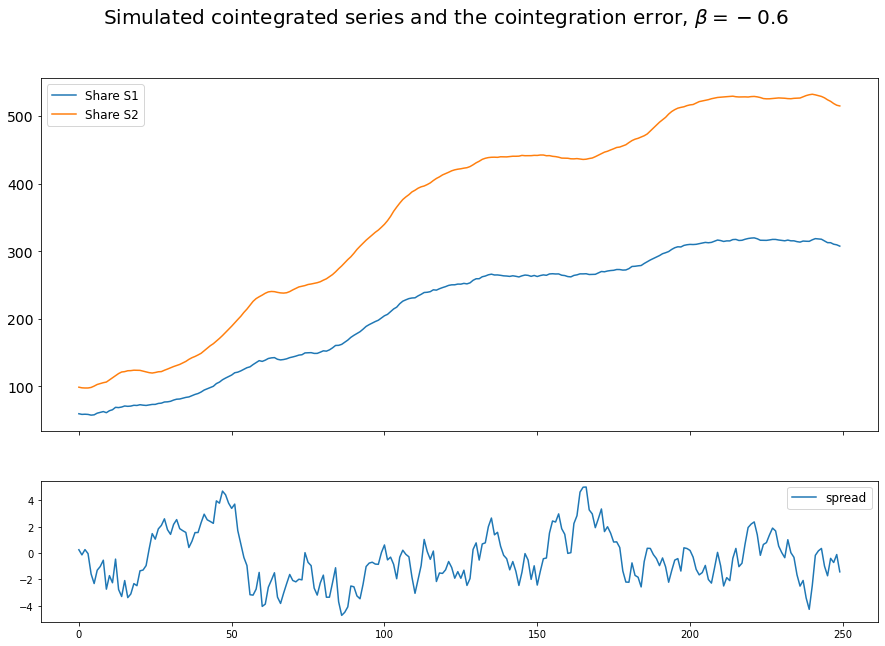

In [5]:
# Plot an example of the simulated cointegrated series and cointegration error.
coint_sim_fig = coint_simulator.plot_coint_series(s1_series[:, 0], s2_series[:, 0], coint_errors[:, 0])

### Minimum Profit Optimization

In this section, the usage of the minimum profit optimization and the performance of the resulting trading strategy will be presented with empirical data. The assets involved in this example are two S&P 500 stocks, Ametek Inc. (Ticker: AME) and Dover Corp. (Ticker: DOV). 

In [6]:
# Read price series data, set date as index.
data = pd.read_csv('AME-DOV.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)

# Show how the price data is structured.
data.head(5)

,AME,DOV
Date,,
2016-01-04,52.65,49.7545
2016-01-05,52.38,48.8101
2016-01-06,51.19,47.7769
2016-01-07,49.98,47.0908
2016-01-08,49.07,46.6873


Although the paper suggested usage of 12-month training period and 6-month trading period with daily data, our results found that the choice of 12-month and 6-month is arbitrary and the performance was not affected if a longer training period were used. In the following demonstration, daily data of both stocks from Jan 4th, 2016 to Dec 31st, 2018 were used for training, and the trading period starts from Jan 2nd, 2019 to Nov 23th, 2020.

In [7]:
# Initialize the minimum profit optimizer.
optimizer = MinimumProfit(data)

# Split the entire price history into training and trading period.
# 2019 Jan 1st was a market holiday so it is a perfect split point.
train_df, trade_df = optimizer.train_test_split(date_cutoff=pd.Timestamp(2019, 1, 1))

The next step is to test if the two stocks stayed cointegrated during the training period. Here we used Engle-Granger test to test for cointegration and retrieve the cointegration coefficient.

In [8]:
beta_eg, epsilon_t_eg, ar_coeff_eg, ar_resid_eg = optimizer.fit(use_johansen=False, sig_level="95%")

C:\Anaconda3\envs\arbitragelab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\Anaconda3\envs\arbitragelab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\Anaconda3\envs\arbitragelab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


If the asset pair is not cointegrated at the designated significance level (here we set it to 95\%), then the `fit()` function will output a warning message that the pair was not cointegrated at the 95\% level. Here the warning did not appear, which means the stock pair (AME-DOV) was cointegrated during the entire training period. 

We can now check the properties of the cointegration error and see how well it follows an AR(1) process.

In [9]:
print("The cointegration coefficient is: {}".format(beta_eg))
print("The AR(1) cofficient of the cointegration error is: {}".format(ar_coeff_eg))
sigma_e = epsilon_t_eg.std()
sigma_a = ar_resid_eg.std()
print("The standard deviation of the cointegration error is: {}".format(sigma_e))
print("The standard deviation of the fitted AR(1) process residual is: {}".format(sigma_a))
print("The ratio of the AR(1) residual std-dev to "
      "cointegration error std-dev is: {}".format(sigma_a / sigma_e))
print("Value of sqrt(1 - phi^2) is: {}".format(np.sqrt(1 - ar_coeff_eg ** 2)))

The cointegration coefficient is: -0.9493904205182062
The AR(1) cofficient of the cointegration error is: 0.9831300177932852
The standard deviation of the cointegration error is: 3.71589045058226
The standard deviation of the fitted AR(1) process residual is: 0.7845711728093724
The ratio of the AR(1) residual std-dev to cointegration error std-dev is: 0.21113947874497602
Value of sqrt(1 - phi^2) is: 0.1829080865182693


According to the above results, we can see that the cointegration error indeed follows a stationary AR(1) process with two pieces of proof.

1. The standard deviation of the cointegration error and the standard deviation of the AR(1) process residual have the following relationship:

\begin{equation}
\sigma_a = \sqrt{1 - \phi^2} \sigma_{\varepsilon}
\end{equation}

And the fitting result has shown that $\frac{\sigma_a}{\sigma_{\varepsilon}} = 0.21$ and $\sqrt{1 - \phi^2} = 0.18$, which is relatively close.

2. The absolute value of the AR(1) coefficient is less than 1 ($\phi = 0.9831 < 1$).

Now we proceed to optimize the upper bound. Note that this process will take a while, so a progress bar has been provided.

In [10]:
# Optimize the pre-set boundaries based on the fitted parameters.
optimal_ub, _, _, optimal_mtp, optimal_num_of_trades = optimizer.optimize(ar_coeff_eg, epsilon_t_eg, 
                                                                          ar_resid_eg, len(train_df))

Progress: |██████████████████████████████████████████████████| 100.0% Complete


Let's check the optimal upper bound, the optimal minimal total profit, and the optimal total number of U-trades. We can simply double the minimal total profit and the number of U-trades to take into account L-trades.

In [11]:
print("The optimal upper-bound is: {}".format(optimal_ub))
print("The optimal minimal total profit over the in-sample period with only U-trades: ${:.2f}".format(optimal_mtp))
print("The optimal total number of U-trades is: {}".format(np.floor(optimal_num_of_trades)))
print("The optimal minimal total profit over the in-sample period with both "
      "U-trades and L-trades: ${:.2f}".format(2. * optimal_mtp))
print("The optimal total number of U-trades and L-trades is: {}".format(2. * np.floor(optimal_num_of_trades)))

The optimal upper-bound is: 2.05
The optimal minimal total profit over the in-sample period with only U-trades: $14.92
The optimal total number of U-trades is: 7.0
The optimal minimal total profit over the in-sample period with both U-trades and L-trades: $29.85
The optimal total number of U-trades and L-trades is: 14.0


The above results correspond to trading one unit of the AME-DOV pair. The optimal upper-bound is $\$2.05$, which is also the minimum profit per trade according to the derivation in the **Minimum Profit Per Trade** section.

### Trading the Strategy

In [12]:
# Obtain the trading signals and number of shares to trade on in-sample data
trade_signals_is, num_of_shares_is, cond_values_is = optimizer.trade_signal(optimal_ub, optimal_ub, 
                                                                            beta_eg, epsilon_t_eg, insample=True)

# Show the number of shares to trade.
num_of_shares_is

array([2., 1.])

The number of shares have been decided by the optimizer. One unit of trade corresponds to trading 2 shares of AME and 1 shares of DOV. Now we initialize a trading account to simulate the trading process and we only allow the account to trade one unit of pair for each trade.

In [13]:
# Initialize a trading account with $1,000.
trade_sim1 = TradingSim(starting_equity=1000.)

# Simulate the trade for in-sample data 
trade_result_is = trade_sim1.summary(trade_signals_is, num_of_shares_is)

# Number of U-trade and L-trade
num_utrade_is = len(trade_result_is[trade_result_is['Trade Type'] == "U-trade Close"])
num_ltrade_is = len(trade_result_is[trade_result_is['Trade Type'] == "L-trade Close"])

print("Number of U-trade in-sample: {}".format(num_utrade_is))
print("Number of L-trade in-sample: {}".format(num_ltrade_is))

# Show last 3 trades
trade_result_is.tail(7)

Number of U-trade in-sample: 5
Number of L-trade in-sample: 5


,Trade Date,Trade Type,Leg 1,Leg 1 Shares,Leg 1 Price,Leg 2,Leg 2 Shares,Leg 2 Price
14,2018-01-09,L-trade Open,AME,2.0,74.00,DOV,-1.0,83.9870
15,2018-01-19,L-trade Close,AME,-2.0,76.98,DOV,1.0,84.2776
16,2018-02-12,U-trade Open,AME,-2.0,74.00,DOV,1.0,79.3215
17,2018-08-20,U-trade Close,AME,2.0,76.58,DOV,-1.0,84.3900
18,2018-09-27,L-trade Open,AME,2.0,78.93,DOV,-1.0,88.9800
19,2018-12-12,L-trade Close,AME,-2.0,72.61,DOV,1.0,78.3400
20,2018-12-18,U-trade Open,AME,-2.0,68.87,DOV,1.0,73.9500


From the above results, we can see that there is still a U-trade open at the end of Dec 18th, 2018. Excluding this trade, we will show the P&L up to Dec 12th, 2018 where the last trade was closed.

Total P&L: $49.04
Average P&L per trade: $4.90


(<Figure size 1080x720 with 2 Axes>, <Figure size 1080x720 with 1 Axes>)

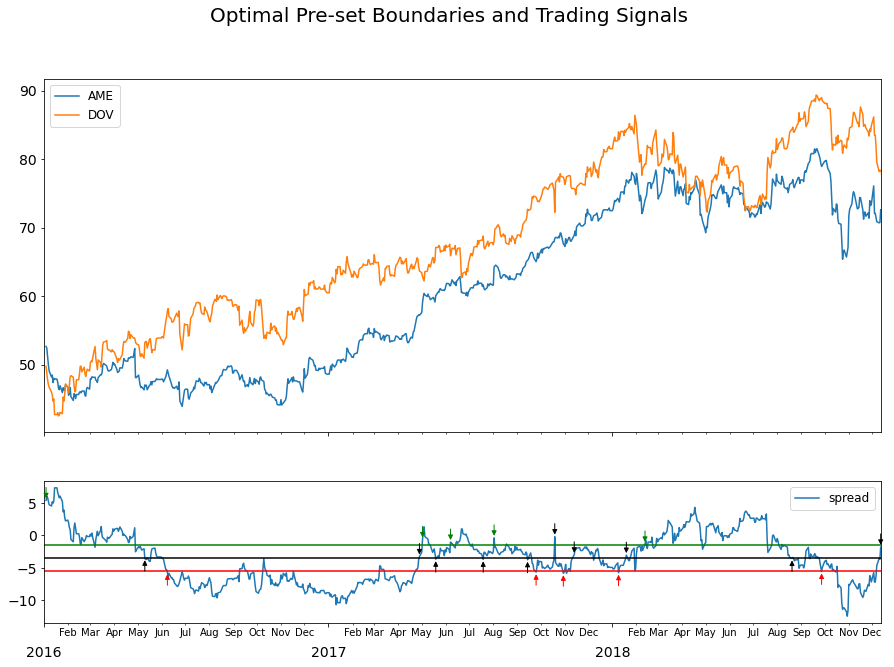

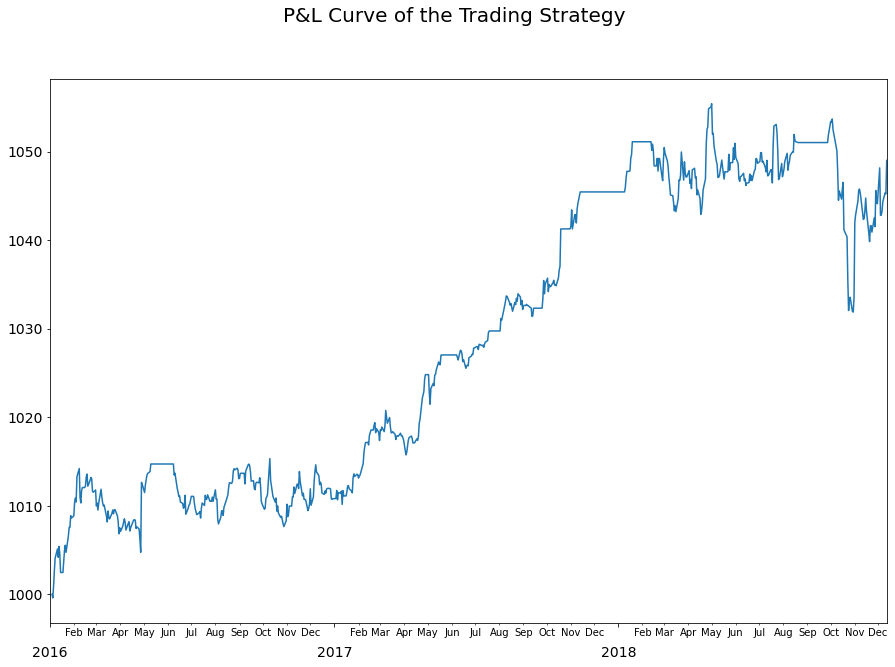

In [14]:
# Show P&L
pnl_df = trade_sim1.get_pnl(trade_signals_is)
pnl = pnl_df.loc[pd.Timestamp(2018, 12, 12)]['Total Equity'] - 1000.
print("Total P&L: ${:.2f}".format(pnl))
print("Average P&L per trade: ${:.2f}".format(pnl / (num_utrade_is + num_ltrade_is)))

# Plot the signals and the P&L curve
trade_sim1.plot_strategy(trade_signals_is, num_of_shares_is, cond_values_is,
                         start_date=pd.Timestamp(2016, 1, 1), end_date=pd.Timestamp(2018, 12, 12))

The pair traded very well during the in-sample period, yielding 5 U-trades and 5 L-trades, and $\$49.04$ profit in total. The average profit per trade is $\$4.90$, which is higher than the optimized average profit per trade $\$2.05$.

Now let's see how well the cointegrated pair trades during the out-of-sample period.

In [15]:
# Obtain the trading signals and number of shares to trade on out-of-sample data
trade_signals_oos, num_of_shares_oos, cond_values_oos = optimizer.trade_signal(optimal_ub, optimal_ub, 
                                                                               beta_eg, epsilon_t_eg, insample=False)

# Initialize a trading account with $1,000.
trade_sim2 = TradingSim(starting_equity=1000.)

# Simulate the trade for in-sample data 
trade_result_oos = trade_sim2.summary(trade_signals_oos, num_of_shares_oos)

# Number of U-trade and L-trade
num_utrade_oos = len(trade_result_oos[trade_result_oos['Trade Type'] == "U-trade Close"])
num_ltrade_oos = len(trade_result_oos[trade_result_oos['Trade Type'] == "L-trade Close"])

print("Number of U-trade out-of-sample: {}".format(num_utrade_oos))
print("Number of L-trade out-of-sample: {}".format(num_ltrade_oos))

# Show last 3 trades
trade_result_oos.tail(7)

Number of U-trade out-of-sample: 9
Number of L-trade out-of-sample: 10


,Trade Date,Trade Type,Leg 1,Leg 1 Shares,Leg 1 Price,Leg 2,Leg 2 Shares,Leg 2 Price
32,2020-08-10,L-trade Open,AME,2.0,99.04,DOV,-1.0,110.50
33,2020-09-29,L-trade Close,AME,-2.0,99.89,DOV,1.0,108.24
34,2020-10-06,U-trade Open,AME,-2.0,104.33,DOV,1.0,110.09
35,2020-10-28,U-trade Close,AME,2.0,98.19,DOV,-1.0,109.29
36,2020-10-29,L-trade Open,AME,2.0,98.91,DOV,-1.0,110.09
37,2020-11-04,L-trade Close,AME,-2.0,105.39,DOV,1.0,114.07
38,2020-11-06,U-trade Open,AME,-2.0,110.32,DOV,1.0,116.42


The coronavirus shock to the stock market yielded more trades for this cointegrated pair during the turbulent year of 2020. Let's see how the P&L looks like.

Total P&L is: 90.12
Average P&L per trade: $4.74


(<Figure size 1080x720 with 2 Axes>, <Figure size 1080x720 with 1 Axes>)

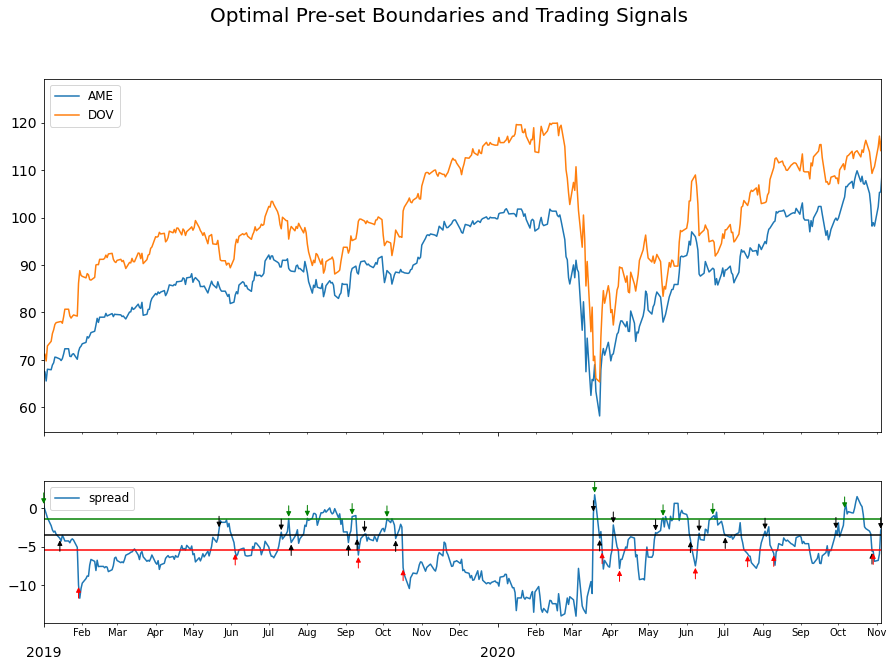

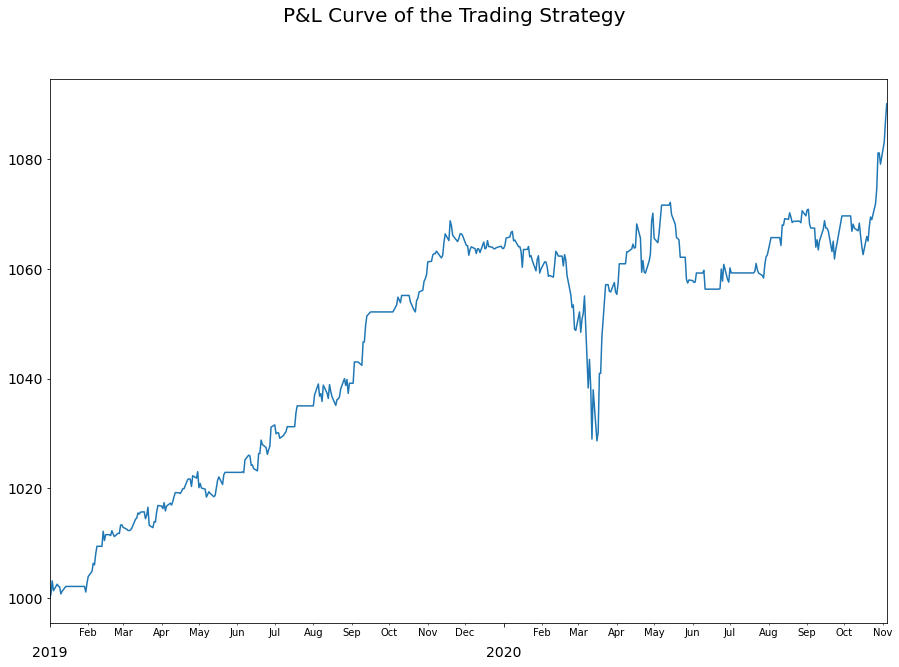

In [16]:
# Show P&L
pnl_df = trade_sim2.get_pnl(trade_signals_oos)
pnl = pnl_df.loc[pd.Timestamp(2020, 11, 4)]['Total Equity'] - 1000.
print("Total P&L is: {:.2f}".format(pnl))
print("Average P&L per trade: ${:.2f}".format(pnl / (num_utrade_oos + num_ltrade_oos)))

# Plot the signals and the P&L curve
trade_sim2.plot_strategy(trade_signals_oos, num_of_shares_oos, cond_values_oos,
                         start_date=pd.Timestamp(2019, 1, 1), end_date=pd.Timestamp(2020,11,4))

From the out-of-sample testing results, we can see the pair maintained its cointegration property and the performance has not deteriorated. The average profit per trade out-of-sample ($\$4.74$) is almost as the same as that in-sample ($\$4.90$), but the special market environment led to more trades.

The minimum profit per trade by trading one unit of the cointegrated pair is $\$2.05$. The stability of out-of-sample tests led to a natural proposition: scale up the strategy. Now let us fund a bigger trading account with $\$1\text{M}$ available to trade. We would like to guarantee a minimum profit per trade of $\$5,000$ (which is 0.5\% of the account), and see how the strategy fares.

In [17]:
# Get a new optimizer
optimizer_big = MinimumProfit(data)
_, _ = optimizer_big.train_test_split(date_cutoff=pd.Timestamp(2019, 1, 1))
beta_eg, epsilon_t_eg, ar_coeff_eg, ar_resid_eg = optimizer_big.fit(use_johansen=False, sig_level="95%")

# Obtain the trading signals and number of shares to trade on out-of-sample data
minimum_profit = 5000.
trade_signals_oos, num_of_shares_oos, cond_values_oos = optimizer_big.trade_signal(optimal_ub, minimum_profit, 
                                                                                   beta_eg, epsilon_t_eg, insample=False)

# Initialize a trading account with $1,000,000.
trade_sim3 = TradingSim(starting_equity=1000000.)

# Simulate the trade for in-sample data 
trade_result_oos = trade_sim3.summary(trade_signals_oos, num_of_shares_oos)

# Show number of shares to trade for each stock
num_of_shares_oos

C:\Anaconda3\envs\arbitragelab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\Anaconda3\envs\arbitragelab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\Anaconda3\envs\arbitragelab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


array([2440., 2316.])

Therefore, we need to trade 2,440 shares of AME and 2,316 shares of DOV to guarantee a minimum profit per trade of $\$5,000$. The P&L curve then looks as follows.

In [18]:
%%capture
signal_plot, pnl_plot = trade_sim3.plot_strategy(trade_signals_oos, num_of_shares_oos, cond_values_oos,
                                                 start_date=pd.Timestamp(2019, 1, 1), end_date=pd.Timestamp(2020,11,4))


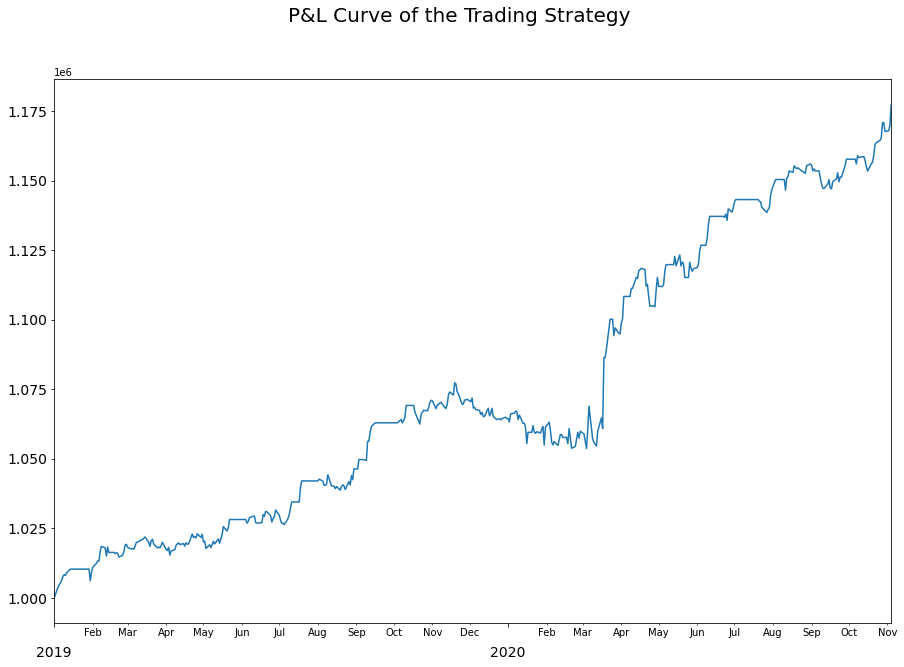

In [19]:
pnl_plot

## Conclusion

This notebook described how to design a cointegrated pair trading strategy by optimizing the pre-set boundaries to "fade the spread" to maximize the minimum total profit over a trading period. The assumptions of the cointegration model, the optimization algorithm, and the application of the algorithm to an empirical pair has been demonstrated in detail.

### Key takeaways

* When trading a cointegrated asset pair, two elements are required to guarantee a minimum profit per trade.
  - Build the spread by weighting the assets by the cointegration coefficient.
  - Fade the spread at a pre-set boundary and square the trade when the spread return to its mean.
* The spread must maintain cointegrated during the training and the trading period.
* If the spread follows a stationary AR(1) process, the optimal pre-set boundary can be estimated with mean first-passage time.
* A numerical algorithm has been given to calculate the mean first-passage time.
* The optimal boundary maximizes the total minimum profit over a trading period.
* By assuming a symmetric distribution of the spread, the optimal boundary is applied over both sides of the spread mean, so the spread can be faded both when overvalued and undervalued.
* The strategy can be scaled up by setting a higher minimum profit per trade.

## Reference

1. Lin, Y.-X., McCrae, M., and Gulati, C. (2006). Loss protection in pairs trading through minimum profit bounds: A cointegration approach.Journal of Applied Mathematics and Decision Sciences, 2006(1):1–14.
2. Puspaningrum, H., Lin, Y.-X., and Gulati, C. M. (2010).  Finding the optimal pre-set boundaries for pairs trading strategy based on cointegration technique. Journal of  Statistical  Theory and Practice, 4(3):391–419.